## Compare photometry in the new  v3.4 Stripe82 catalog 
## to Gaia EDR3 photometry and derive corrections for 
## gray systematics using Gmag photometry

In [2]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from astroML.plotting import hist
# for astroML installation see https://www.astroml.org/user_guide/installation.html

In [3]:
## automatically reload any modules read below that might have changed (e.g. plots)
%load_ext autoreload
%autoreload 2
# importing ZI and KT tools: 
import ZItools as zit
import KTtools as ktt

<a id='dataReading'></a>

### Define paths and catalogs 

In [4]:
ZIdataDir = "/Users/ivezic/Work/Science/CalibrationV2/SDSS_SSC/Data"
# the original SDSS catalog from 2007
sdssOldCat = ZIdataDir + "/" + "stripe82calibStars_v2.6.dat"
# INPUT: Karun's new catalog from 2020
sdssNewCatIn = ZIdataDir + "/" + "stripe82calibStars_v3.4.dat"
readFormat = 'ascii'
# Gaia EDR3 with BP and RP data
GaiaEDR3CatBR = ZIdataDir + "/" + "Stripe82_GaiaEDR3_BPRP.dat" 
# if you don't have the above file, copy it as: 
# http://faculty.washington.edu/ivezic/sdss/calib82/dataV2/Stripe82_GaiaEDR3_BPRP.dat

In [5]:
# both new and old files use identical data structure
colnamesSDSS = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

In [6]:
%%time
# old
sdssOld = Table.read(sdssOldCat, format='ascii', names=colnamesSDSS) 
np.size(sdssOld)

CPU times: user 23.1 s, sys: 4.47 s, total: 27.6 s
Wall time: 26.7 s


1006849

In [7]:
%%time
# new 
sdssNew = Table.read(sdssNewCatIn, format=readFormat, names=colnamesSDSS)
np.size(sdssNew)

CPU times: user 22.4 s, sys: 4.41 s, total: 26.8 s
Wall time: 26 s


991472

#### Simple positional match using ra/dec

In [8]:
sdssOld_coords = SkyCoord(ra = sdssOld['ra']*u.degree, dec= sdssOld['dec']*u.degree) 
sdssNew_coords = SkyCoord(ra = sdssNew['ra']*u.degree, dec= sdssNew['dec']*u.degree) 
# this is matching sdssNew to sdssOld, so that indices are into sdssNew catalog
# makes sense in this case since the sdssOld catalog is (a little bit) bigger 
# than sdssNew (1006849 vs 1005470)
idx, d2d, d3d = sdssNew_coords.match_to_catalog_sky(sdssOld_coords)  

In [9]:
# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
new_old = hstack([sdssNew, sdssOld[idx]], table_names = ['new', 'old'])
new_old['sep_2d_arcsec'] = d2d.arcsec
# good matches between the old and new catalogs
MAX_DISTANCE_ARCSEC = 0.5
sdss = new_old[(new_old['sep_2d_arcsec'] < MAX_DISTANCE_ARCSEC)]
print(np.size(sdss))

991472


### apply standard cuts as in old catalog:


In [10]:
mOK3 = sdss[sdss['ra_new']<1]
mOK3 = zit.selectCatalog(sdss, mOK3)

starting with 991472
after Nobs cuts: 991472
after chi2 cuts: 991472
after r_mErr cut: 991437


In [11]:
print(996147/1006849)
print(993774/1006849)
print(991472/1006849)

0.989370799394944
0.9870139415145668
0.9847276006630588


### now match to Gaia DR2...

In [12]:
colnamesGaia = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr', 'pmra', 'pmdec']
colnamesGaia = colnamesGaia + ['BPmag', 'BPeI', 'RPmag', 'RPeI', 'BRef']
gaia = Table.read(GaiaEDR3CatBR, format='ascii', names=colnamesGaia)
gaia['raG'] = gaia['ra']
gaia['decG'] = gaia['dec']    
gaia['GmagErr'] = gaia['fluxErr'] / gaia['flux'] 
gaia['BR'] = gaia['BPmag'] - gaia['RPmag'] 
gaia['GBP'] = gaia['Gmag'] - gaia['BPmag']
gaia['GRP'] = gaia['Gmag'] - gaia['RPmag']

In [13]:
sdss_coords = SkyCoord(ra = sdss['ra_old']*u.degree, dec= sdss['dec_old']*u.degree) 
gaia_coords = SkyCoord(ra = gaia['raG']*u.degree, dec= gaia['decG']*u.degree) 

# this is matching gaia to sdss, so that indices are into sdss catalog
# makes sense in this case since the sdss catalog is bigger than gaia
idxG, d2dG, d3dG = gaia_coords.match_to_catalog_sky(sdss_coords)  

# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
gaia_sdss = hstack([gaia, sdss[idxG]], table_names = ['gaia', 'sdss'])
gaia_sdss['sepSG_2d_arcsec'] = d2dG.arcsec

In [14]:
### code for generating new quantities, such as dra, ddec, colors, differences in mags, etc
def derivedColumns(matches):
    matches['dra'] = (matches['ra_new']-matches['ra_old'])*3600
    matches['ddec'] = (matches['dec_new']-matches['dec_old'])*3600
    matches['ra'] = matches['ra_old']
    ra = matches['ra'] 
    matches['raW'] = np.where(ra > 180, ra-360, ra) 
    matches['dec'] = matches['dec_old']
    matches['u'] = matches['u_mMed_old']
    matches['g'] = matches['g_mMed_old']
    matches['r'] = matches['r_mMed_old']
    matches['i'] = matches['i_mMed_old']
    matches['z'] = matches['z_mMed_old']
    matches['ug'] = matches['u_mMed_old'] - matches['g_mMed_old']
    matches['gr'] = matches['g_mMed_old'] - matches['r_mMed_old']
    matches['ri'] = matches['r_mMed_old'] - matches['i_mMed_old']
    matches['gi'] = matches['g_mMed_old'] - matches['i_mMed_old']
    matches['du'] = matches['u_mMed_old'] - matches['u_mMed_new']
    matches['dg'] = matches['g_mMed_old'] - matches['g_mMed_new']
    matches['dr'] = matches['r_mMed_old'] - matches['r_mMed_new']
    matches['di'] = matches['i_mMed_old'] - matches['i_mMed_new']
    matches['dz'] = matches['z_mMed_old'] - matches['z_mMed_new']
    # Gaia 
    matches['draGold'] = -3600*(matches['ra_old'] - matches['raG']) 
    matches['draGnew'] = -3600*(matches['ra_new'] - matches['raG']) 
    matches['ddecGold'] = -3600*(matches['dec_old'] - matches['decG']) 
    matches['ddecGnew'] = -3600*(matches['dec_new'] - matches['decG']) 
    # photometric
    matches['gGr_old'] = matches['Gmag'] - matches['r_mMed_old']
    matches['gGr_new'] = matches['Gmag'] - matches['r_mMed_new']
    matches['gRPr_new'] = matches['RPmag'] - matches['r_mMed_new']
    return

In [15]:
derivedColumns(gaia_sdss) 

### Select good matches and compare both catalogs to Gaia EDR3

In [16]:
# doGaiaAll(mOK)
def doGaiaGmagCorrection(d, Cstr, Gmax=20.0, yMax=0.03):
    # Cstr = 'gGr_old' or 'gGr_new'  
    gi = d['gi']
    Gr = d[Cstr]
    Gmag = d['Gmag']
    zit.qpBM(d, 'gi', -1, 4.5, Cstr, -2, 1.0, 56) 

    xBin, nPts, medianBin, sigGbin = zit.fitMedians(gi, Gr, -0.7, 4.0, 47, 0)  
    data = np.array([xBin, medianBin, sigGbin])
    Ndata = xBin.size
    ### HERE WE ARE FITTING 7-th ORDER POLYNOMIAL TO Gmag-rSDSS vs. g-i ###
    # get best-fit parameters  
    thetaCloc = zit.best_theta(data,7)
    # generate best fit lines on a fine grid 
    xfit = np.linspace(-1.1, 4.3, 1000)
    yfit = zit.polynomial_fit(thetaCloc, xfit) 
    ## added "Poly" because switched to piecewise linear interpolation below
    d['gGrFitPoly'] = zit.polynomial_fit(thetaCloc, gi)
    d['dgGrPoly'] = d[Cstr] - d['gGrFitPoly']  
    ### PIECEWISE LINEAR INTERPOLATION (AS FOR ALL OTHER COLORS AND SURVEYS)
    d['gGrFit'] = np.interp(gi, xBin, medianBin)
    d['dgGr'] = d[Cstr] - d['gGrFit']   
    
    # SELECT FOR RECALIBRATION wrt RA and Dec
    giMin = 0.4
    giMax = 3.0 
    Dc = d[(d['gi']>giMin)&(d['gi']<giMax)]
    print('N before and after color cut:', np.size(d), np.size(Dc))
    DcB = Dc[(Dc['Gmag']>14.5)&(Dc['Gmag']<Gmax)]
    DcB['GrResid'] = DcB['dgGr'] - np.median(DcB['dgGr'])
    zit.printStats(DcB['dgGr'])
    DcBok = DcB[np.abs(DcB['dgGr'])<0.1]
    print(np.size(DcB), np.size(DcBok))

    zit.qpBM(DcBok, 'Gmag', 14.5, Gmax, 'GrResid', -1*yMax, yMax, 56) 
    zit.qpBM(DcBok, 'dec', -1.3, 1.3, 'GrResid', -1*yMax, yMax, 126) 
    zit.qpBM(DcBok, 'raW', -51.5, 60, 'GrResid', -1*yMax, yMax, 112) 
    
    return thetaCloc, DcBok 

In [17]:
## first limit astrometric distance and 
## require at least 4 epochs as in the old catalog
MAX_DISTANCE_ARCSEC = 0.5
m1 = gaia_sdss[(gaia_sdss['sepSG_2d_arcsec'] < MAX_DISTANCE_ARCSEC)]
a1 = m1['g_Nobs_new']
a2 = m1['r_Nobs_new']
a3 = m1['i_Nobs_new']
mOK = m1[(a1>3)&(a2>3)&(a3>3)]
print(len(new_old))
print(len(m1))
print(len(mOK))

991472
905428
905428


In [18]:
def plotAstro2Ddiagrams(d):
    ### plots 
    plotNameRoot = 'astroVSpm_RA_pm'
    plotName = plotNameRoot + '.png'    
    kw = {"Xstr":'pmra', "Xmin":-40, "Xmax":40, "Xlabel":'R.A. proper motion (mas/yr)', \
          "Ystr":'draGnew', "Ymin":-0.5, "Ymax":0.5, "Ylabel":'raw SDSS R.A. - Gaia R.A. (arcsec)', \
          "XminBin":-35, "XmaxBin":35, "nBin":70, \
          "plotName":plotName, "Nsigma":0, "offset":-0.1, "symbSize":0.05}
    kw["nBinX"] = 90
    kw["nBinY"] = 40
    kw["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(d, kw)
    print('made plot', plotName)

    # need to fit draGnew vs. pmra and correct for the mean trend, then plot vs. r mag
    pmra = d['pmra']
    draGnew = d['draGnew']
    xBin, nPts, medianBin, sigGbin = zit.fitMedians(pmra, draGnew, -60, 60, 120, 0)  
    ### PIECEWISE LINEAR INTERPOLATION 
    d['draGnewFit'] = np.interp(d['pmra'], xBin, medianBin)
    draCorr = d['draGnew'] - d['draGnewFit'] 
    draCorrOK = np.where(np.abs(draCorr) < 0.25, draCorr, 0)
    d['draGnewCorr'] = draCorrOK   

    plotNameRoot = 'astroVSpm_RA_r'
    plotName = plotNameRoot + '.png'  
    kw = {"Xstr":'r_mMed_new', "Xmin":14, "Xmax":21, "Xlabel":'SDSS r magnitude', \
          "Ystr":'draGnewCorr', "Ymin":-0.12, "Ymax":0.12, "Ylabel":'corr. SDSS R.A. - Gaia R.A. (arcsec)', \
          "XminBin":14, "XmaxBin":21, "nBin":30, \
          "plotName":plotName, "Nsigma":0, "offset":0.050, "symbSize":0.05}
    kw["nBinX"] = 30
    kw["nBinY"] = 24
    kw["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(d, kw)
    print('made plot', plotName)


    plotNameRoot = 'astroVSpm_Dec_pm'
    plotName = plotNameRoot + '.png'    
    kw = {"Xstr":'pmdec', "Xmin":-40, "Xmax":40, "Xlabel":'Dec. proper motion (mas/yr)', \
          "Ystr":'ddecGnew', "Ymin":-0.5, "Ymax":0.5, "Ylabel":'raw SDSS Dec. - Gaia Dec. (arcsec)', \
          "XminBin":-35, "XmaxBin":35, "nBin":70, \
          "plotName":plotName, "Nsigma":0, "offset":-0.1, "symbSize":0.05}
    kw["nBinX"] = 90
    kw["nBinY"] = 40
    kw["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(d, kw)
    print('made plot', plotName)

medianAll: 0.011903239737875992 std.dev.All: 0.0845129902414965
N= 905428 min= -0.7530682099286423 max= 0.857299626591157
median: -0.0007162202031452125 std.dev: 0.2582687052783536
saved plot as: astroVSpm_RA_pm.png


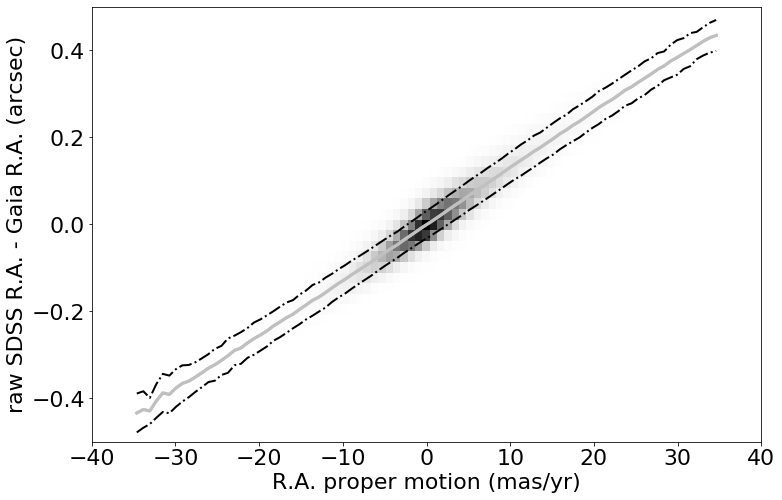

made plot astroVSpm_RA_pm.png
medianAll: 0.0 std.dev.All: 0.0280871392952278
N= 905428 min= -0.2480811471216493 max= 0.24856338973925046
median: 0.0005832896333058564 std.dev: 0.0016611285846833677
saved plot as: astroVSpm_RA_r.png


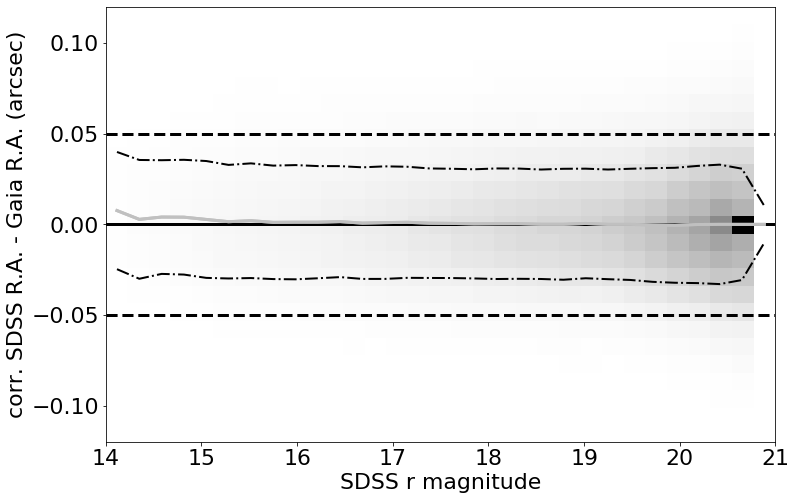

made plot astroVSpm_RA_r.png
medianAll: -0.06763680758929969 std.dev.All: 0.06964391458366558
N= 905428 min= -0.6355469751649245 max= 0.5258908825483743
median: -0.004166888275625169 std.dev: 0.26026356986089966
saved plot as: astroVSpm_Dec_pm.png


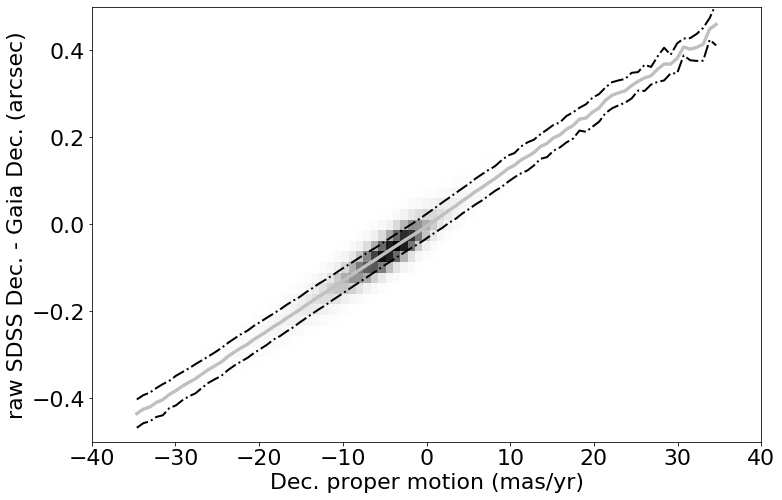

made plot astroVSpm_Dec_pm.png


In [19]:
### produce astrometric plots showing correlation with proper motions
plotAstro2Ddiagrams(mOK)
# print(np.std(mOK['draGnew']), np.std(mOK['ddecGnew'])) 
#mOK

In [20]:
x = mOK['draGnewCorr']
xOK = x[np.abs(x)<0.25]
print(np.std(xOK), zit.sigG(xOK))

0.03228158828022927 0.0280871392952278


medianAll: 0.011903239737875992 std.dev.All: 0.0845129902414965
N= 905428 min= -0.7530682099286423 max= 0.857299626591157
median: -0.0007743212407262945 std.dev: 0.36092870707181657


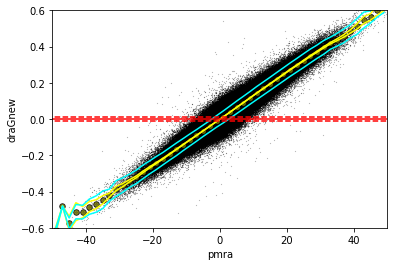

In [21]:
zit.qpBM(mOK, 'pmra', -50, 50, 'draGnew', -0.6, 0.6, 50) 

medianAll: -0.06763680758929969 std.dev.All: 0.06964391458366558
N= 905428 min= -0.6355469751649245 max= 0.5258908825483743
median: -0.04169173801793491 std.dev: 0.3189931753210442


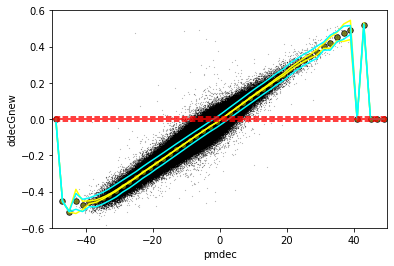

In [22]:
zit.qpBM(mOK, 'pmdec', -50, 50, 'ddecGnew', -0.6, 0.6, 50) 

medianAll: -0.010385025024413963 std.dev.All: 0.2146897515792855
N= 905428 min= -4.998144592285158 max= 3.468589370727539
median: -0.15756506347656085 std.dev: 0.5849594467402839


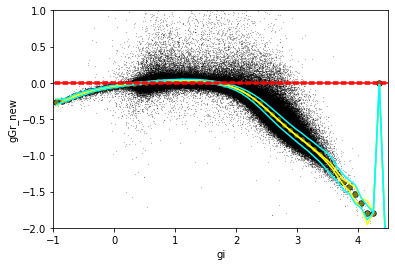

N before and after color cut: 905428 858943
            -5.016675328979494 0.00639240481825247 0.0019858921051022094 3.4367255667114254 544990
544990 525846
medianAll: -0.00036593910217177193 std.dev.All: 0.015747110472907923
N= 525846 min= -0.10198102455139342 max= 0.09800814140319695
median: 0.0008467535591129584 std.dev: 0.0034685641071798483


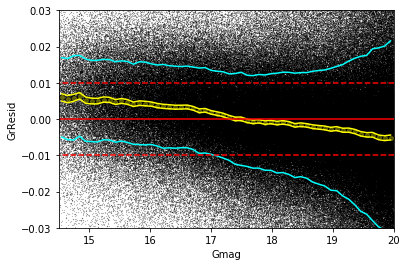

medianAll: -0.00036593910217177193 std.dev.All: 0.015747110472907923
N= 525846 min= -0.10198102455139342 max= 0.09800814140319695
median: -0.000407903909683165 std.dev: 0.0005758733302931167


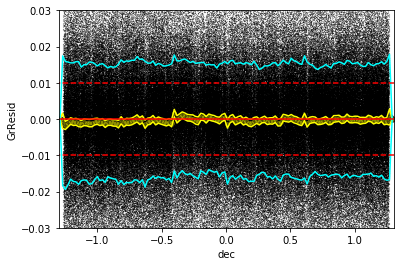

medianAll: -0.00036593910217177193 std.dev.All: 0.015747110472907923
N= 525846 min= -0.10198102455139342 max= 0.09800814140319695
median: 0.0013344456481929395 std.dev: 0.002231450942547468


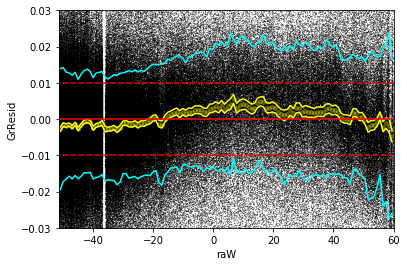

In [23]:
theta, mOKc = doGaiaGmagCorrection(mOK, 'gGr_new')
thetaLoc = theta

In [24]:
## for zero point calibration, in addition to color cut in doGaiaAll, take 16 < G < 19.5 
mOKcB = mOKc[(mOKc['Gmag']>16)&(mOKc['Gmag']<19.5)]
mOKcB['GrResid'] = mOKcB['dgGr'] - np.median(mOKcB['dgGr'])
mOKcBok = mOKcB[np.abs(mOKcB['dgGr'])<0.1]
print(np.size(mOKc), np.size(mOKcB), np.size(mOKcBok))

525846 373698 373698


In [25]:
print(np.std(mOKcBok['GrResid']), zit.sigG(mOKcBok['GrResid'])) 

0.023988378568647897 0.014477569533062593


medianAll: 0.0 std.dev.All: 0.014477569533062593
N= 373698 min= -0.10152685428619615 max= 0.09845405254364395
median: -5.252639770503579e-05 std.dev: 0.0006408338357396181


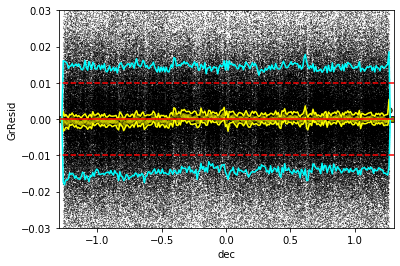

In [26]:
zit.qpBM(mOKcBok, 'dec', -1.3, 1.3, 'GrResid', -0.03, 0.03, 260) 

medianAll: 0.0 std.dev.All: 0.014477569533062593
N= 373698 min= -0.10152685428619615 max= 0.09845405254364395
median: 0.001188350677489456 std.dev: 0.0019196611841049158


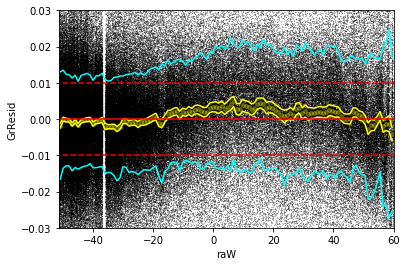

In [27]:
zit.qpBM(mOKcBok, 'raW', -51.5, 60, 'GrResid', -0.03, 0.03, 112) 

# Final Figures for the Paper 
## with Karun's 2D histogram implementation

In [28]:
def plotGmag2Ddiagrams(d):
    ### plots 
    plotNameRoot = 'GrVSgi'
    plotName = plotNameRoot + '.png'    
    kw = {"Xstr":'gi', "Xmin":0.0, "Xmax":3.5, "Xlabel":'SDSS g-i', \
          "Ystr":'gGr_new', "Ymin":-1.25, "Ymax":0.25, "Ylabel":'Gaia Gmag - SDSS r', \
          "XminBin":-0.5, "XmaxBin":4.0, "nBin":90, \
          "plotName":plotName, "Nsigma":3, "offset":0.0, "symbSize":0.05}
    kw["nBinX"] = 90
    kw["nBinY"] = 40
    kw["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(d, kw)
    print('made plot', plotName)

def plotGmag2DdiagramsX(d, kw):
    # Gaia G
    print('-----------')
    print(' stats for SDSS r binning medians:')
    plotName = plotNameRoot + '_Gmag.png'    
    kwOC = {"Xstr":'Gmag', "Xmin":14.3, "Xmax":21.01, "Xlabel":'Gaia G (mag)', \
          "Ystr":kw['Ystr'], "Ymin":-0.06, "Ymax":0.06, "Ylabel":Ylabel, \
          "XminBin":14.5, "XmaxBin":21.0, "nBin":130, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_Gmag_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 130
    kwOC["nBinY"] = 50
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)
    print('made plot', plotName)
    print('------------------------------------------------------------------')

In [29]:
def plotGmagCorrections(d, kw):
    ### REDEFINE residuals to correspond to "SDSS-others", as other cases
    d['redef'] = -1*d[kw['Ystr']] 
    kw['Ystr'] = 'redef'
    goodC = d[np.abs(d['redef'])<0.1]
    
    ### plots 
    plotNameRoot = kw['plotNameRoot']
    # RA
    print(' stats for RA binning medians:')
    plotName = plotNameRoot + '_RA.png'
    Ylabel = 'residuals for (Gmag$_{SDSS}$ - Gmag$_{GaiaEDR3}$)  '
    kwOC = {"Xstr":'raW', "Xmin":-52, "Xmax":60.5, "Xlabel":'R.A. (deg)', \
          "Ystr":kw['Ystr'], "Ymin":-0.07, "Ymax":0.07, "Ylabel":Ylabel, \
          "XminBin":-51.5, "XmaxBin":60, "nBin":112, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_RA_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 112
    kwOC["nBinY"] = 50
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)  
    print('made plot', plotName)

    # Dec
    print('-----------')
    print(' stats for Dec binning medians:')
    plotName = plotNameRoot + '_Dec.png'
    kwOC = {"Xstr":'dec', "Xmin":-1.3, "Xmax":1.3, "Xlabel":'Declination (deg)', \
          "Ystr":kw['Ystr'], "Ymin":-0.07, "Ymax":0.07, "Ylabel":Ylabel, \
          "XminBin":-1.266, "XmaxBin":1.264, "nBin":252, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_Dec_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 252  
    kwOC["nBinY"] = 50
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)
    print('made plot', plotName)   
    
    # Gaia G
    print('-----------')
    print(' stats for SDSS r binning medians:')
    plotName = plotNameRoot + '_Gmag.png'    
    kwOC = {"Xstr":'Gmag', "Xmin":14.3, "Xmax":21.01, "Xlabel":'Gaia G (mag)', \
          "Ystr":kw['Ystr'], "Ymin":-0.06, "Ymax":0.06, "Ylabel":Ylabel, \
          "XminBin":14.5, "XmaxBin":21.0, "nBin":130, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_Gmag_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 130
    kwOC["nBinY"] = 50
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)
    print('made plot', plotName)
    print('------------------------------------------------------------------')
 

In [44]:
mOK['GrResid'] = mOK['dgGr'] - np.median(mOK['dgGr']) - 0.0016
mOKok = mOK[np.abs(mOK['dgGr'])<0.1]
print(np.size(mOK), np.size(mOKok))

905428 842587


 stats for RA binning medians:
medianAll: 0.001887859802246964 std.dev.All: 0.02104595134437597
N= 841390 min= -0.09823625640869378 max= 0.09999942390442042
median: -4.17006492605006e-05 std.dev: 0.002245714982069066
saved plot as: GmagCorrectionEDR3_RA.png


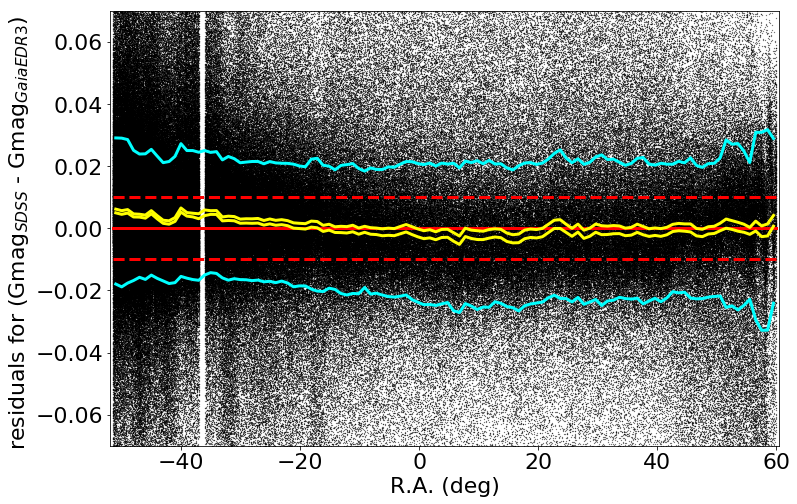

medianAll: 0.001887859802246964 std.dev.All: 0.02104595134437597
N= 841390 min= -0.09823625640869378 max= 0.09999942390442042
median: -4.17006492605006e-05 std.dev: 0.002245714982069066
saved plot as: GmagCorrectionEDR3_RA_Hess.png


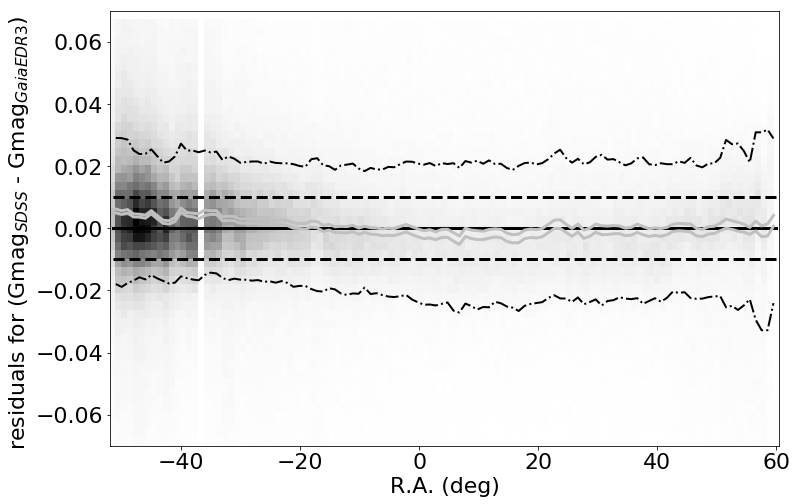

made plot GmagCorrectionEDR3_RA_Hess.png
-----------
 stats for Dec binning medians:
medianAll: 0.001887859802246964 std.dev.All: 0.02104595134437597
N= 841390 min= -0.09823625640869378 max= 0.09999942390442042
median: 0.001961420869829188 std.dev: 0.0009330295617396768
saved plot as: GmagCorrectionEDR3_Dec.png


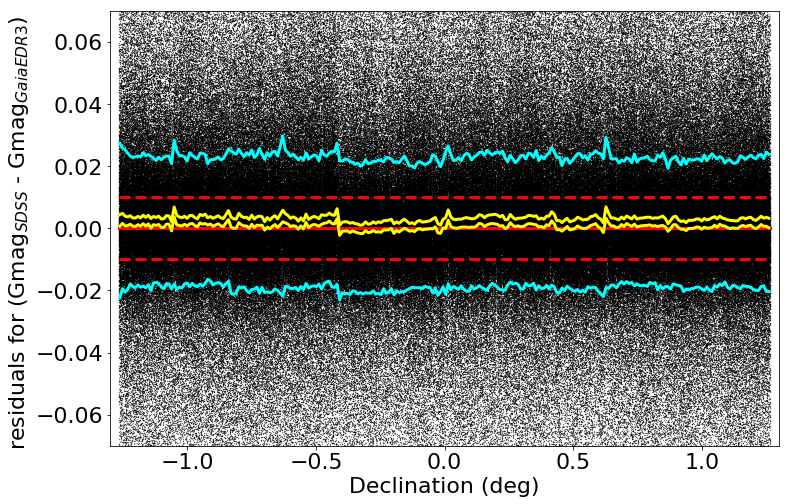

medianAll: 0.001887859802246964 std.dev.All: 0.02104595134437597
N= 841390 min= -0.09823625640869378 max= 0.09999942390442042
median: 0.001961420869829188 std.dev: 0.0009330295617396768
saved plot as: GmagCorrectionEDR3_Dec_Hess.png


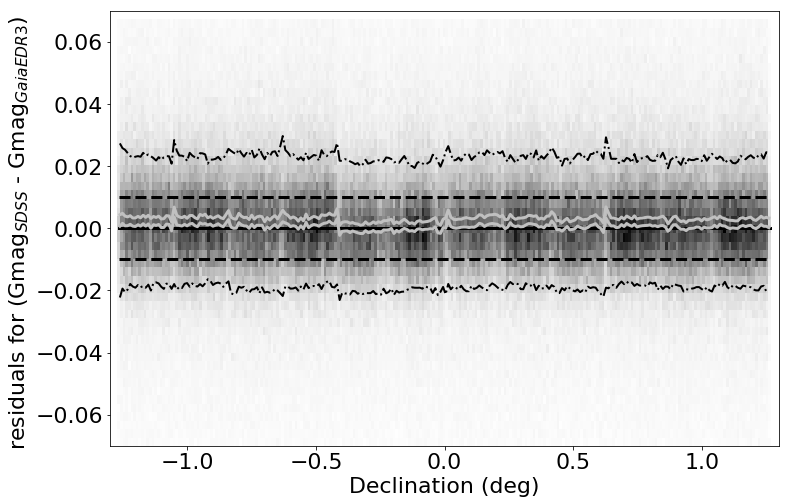

made plot GmagCorrectionEDR3_Dec_Hess.png
-----------
 stats for SDSS r binning medians:
medianAll: 0.001887859802246964 std.dev.All: 0.02104595134437597
N= 841390 min= -0.09823625640869378 max= 0.09999942390442042
median: 0.0005557284927377069 std.dev: 0.005095874810190568
saved plot as: GmagCorrectionEDR3_Gmag.png


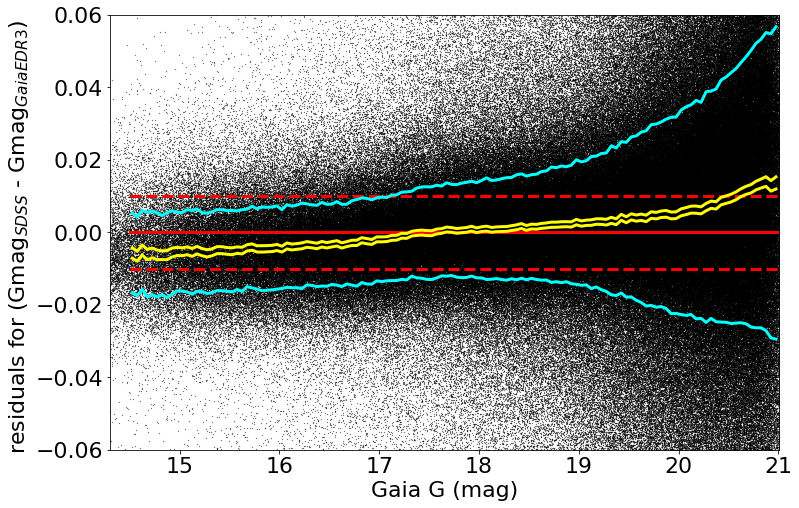

medianAll: 0.001887859802246964 std.dev.All: 0.02104595134437597
N= 841390 min= -0.09823625640869378 max= 0.09999942390442042
median: 0.0005557284927377069 std.dev: 0.005095874810190568
saved plot as: GmagCorrectionEDR3_Gmag_Hess.png


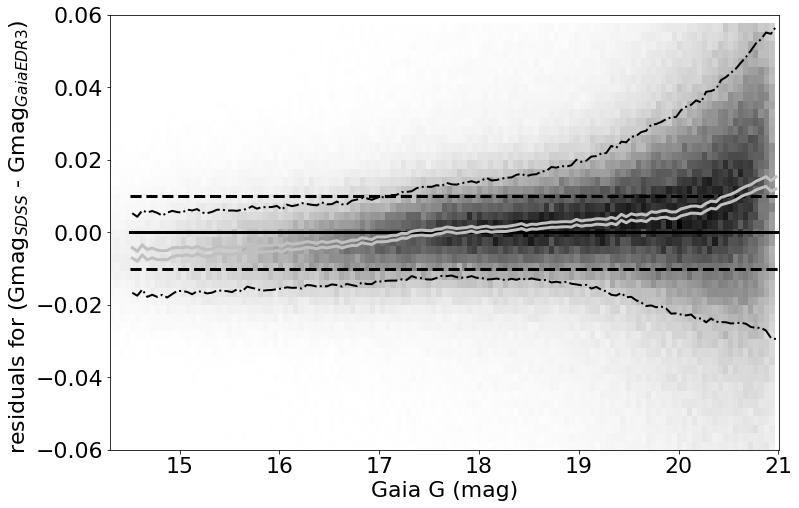

made plot GmagCorrectionEDR3_Gmag_Hess.png
------------------------------------------------------------------


In [45]:
keywords = {"Ystr":'GrResid', "plotNameRoot":'GmagCorrectionEDR3', "symbSize":0.05}
plotGmagCorrections(mOKok, keywords) 

In [33]:
!cp GmagCorrectionEDR3_Gmag_Hess.png GmagCorrectionTestEDR3_Gmag_Hess.png
!cp GmagCorrectionEDR3_RA_Hess.png GmagCorrectionTestEDR3_RA_Hess.png
!cp GmagCorrectionEDR3_Dec_Hess.png GmagCorrectionTestEDR3_Dec_Hess.png

 stats for RA binning medians:
medianAll: 0.0012663321685786018 std.dev.All: 0.01451152008087211
N= 383640 min= -0.09998936836242732 max= 0.09982478889465682
median: 0.002307694416045056 std.dev: 0.0018073012072342275
saved plot as: GmagCorrectionEDR3_RA.png


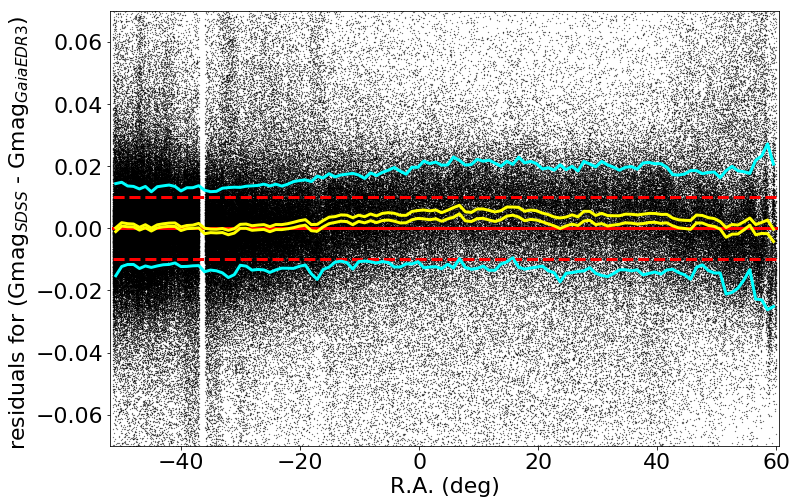

medianAll: 0.0012663321685786018 std.dev.All: 0.01451152008087211
N= 383640 min= -0.09998936836242732 max= 0.09982478889465682
median: 0.002307694416045056 std.dev: 0.0018073012072342275
saved plot as: GmagCorrectionEDR3_RA_Hess.png


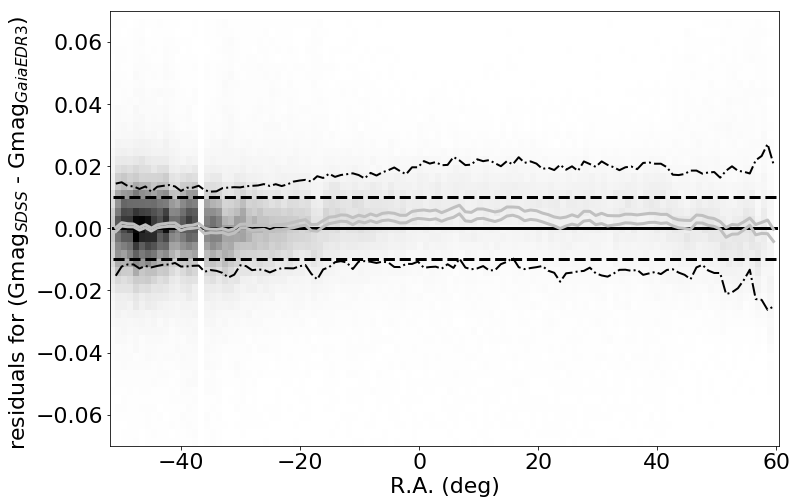

made plot GmagCorrectionEDR3_RA_Hess.png
-----------
 stats for Dec binning medians:
medianAll: 0.0012663321685786018 std.dev.All: 0.01451152008087211
N= 383640 min= -0.09998936836242732 max= 0.09982478889465682
median: 0.0012597010040286112 std.dev: 0.000694833579138259
saved plot as: GmagCorrectionEDR3_Dec.png


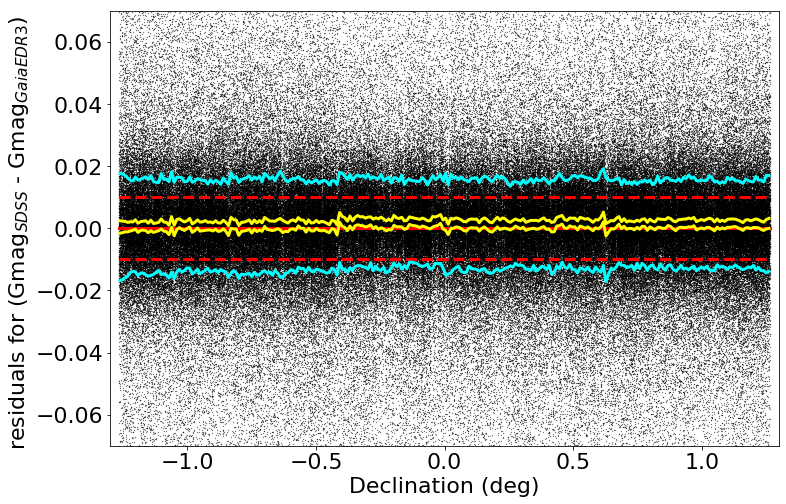

medianAll: 0.0012663321685786018 std.dev.All: 0.01451152008087211
N= 383640 min= -0.09998936836242732 max= 0.09982478889465682
median: 0.0012597010040286112 std.dev: 0.000694833579138259
saved plot as: GmagCorrectionEDR3_Dec_Hess.png


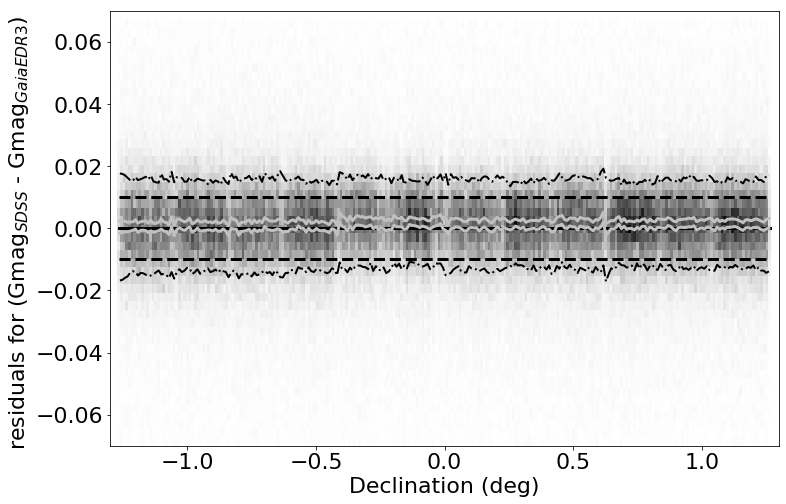

made plot GmagCorrectionEDR3_Dec_Hess.png
-----------
 stats for SDSS r binning medians:
medianAll: 0.0012663321685786018 std.dev.All: 0.01451152008087211
N= 383640 min= -0.09998936836242732 max= 0.09982478889465682
median: 0.0010361193084709838 std.dev: 0.0023678634636214524
saved plot as: GmagCorrectionEDR3_Gmag.png


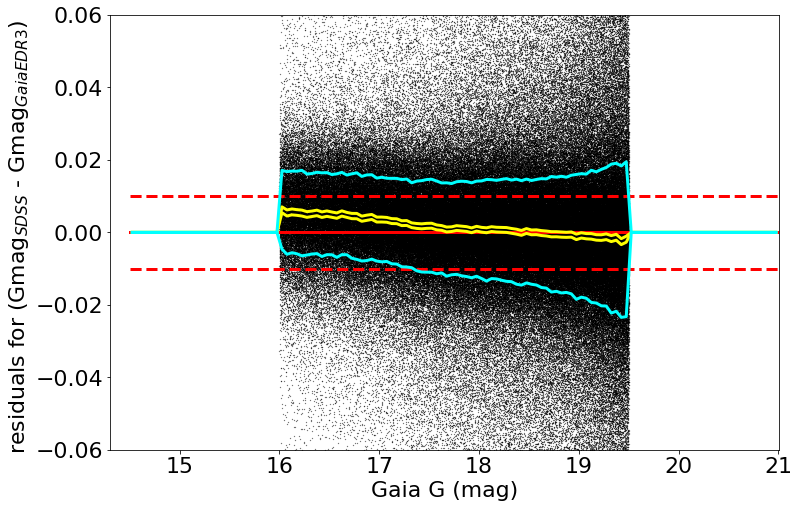

medianAll: 0.0012663321685786018 std.dev.All: 0.01451152008087211
N= 383640 min= -0.09998936836242732 max= 0.09982478889465682
median: 0.0010361193084709838 std.dev: 0.0023678634636214524
saved plot as: GmagCorrectionEDR3_Gmag_Hess.png


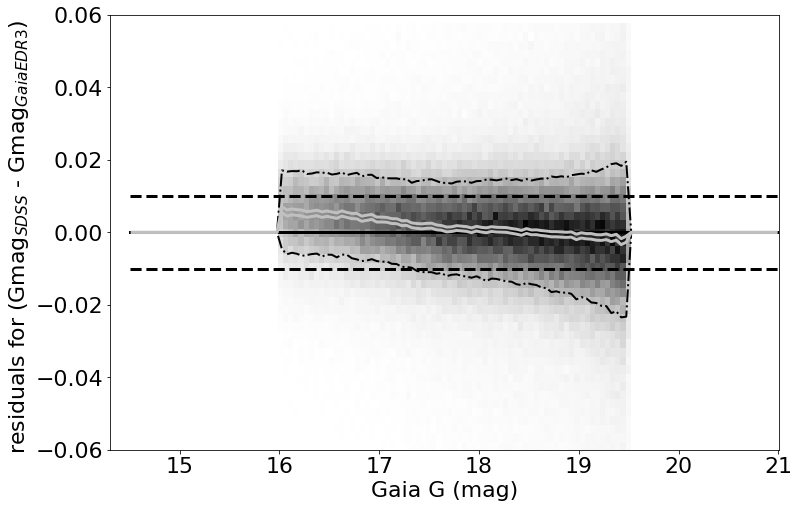

made plot GmagCorrectionEDR3_Gmag_Hess.png
------------------------------------------------------------------


In [37]:
mOKB = mOKok[(mOKok['Gmag']>16)&(mOKok['Gmag']<19.5)]
mOKB['GrResid'] = mOKB['GrResid'] + 0.015
plotGmagCorrections(mOKB, keywords) 

## paper plot showing the jump in Gaia Gmag

medianAll: -0.005981470108033601 std.dev.All: 0.02110171173288418
N= 842587 min= -0.10582076683044458 max= 0.09417625640869379
median: 6.2767696375472075e-06 std.dev: 0.0010742703855429047


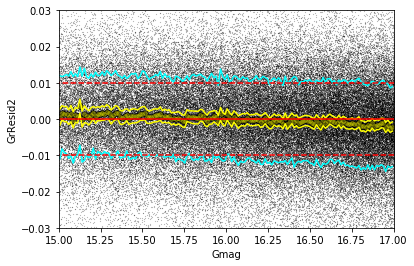

In [41]:
d = mOKok
gi = d['Gmag']
Gr = d['gGr_new']
Gmag = d['Gmag']
d['GrResid2'] = d['GrResid'] - 0.00566
zit.qpBM(d, 'Gmag', 15, 17, 'GrResid2', -0.03, 0.03, 150) 